# Data Preprocessing

In [2]:
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

In [3]:
# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'
input_window = 9
output_window = 1  

sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= input_window + output_window: 
                values_temp = data['Loss'].values
                if max(values_temp) < 2.5 and min(values_temp) >= 0:  # make sure data makes sense
                    sequences.append(values_temp)
        except:
            print(filename)

flattened = list(itertools.chain(*sequences))
mean, std = np.mean(flattened), np.std(flattened)
print("number of sequences:", len(sequences), "mean:", mean, "std:", std)

number of sequences: 424 mean: 0.6949442123005762 std: 0.4846767002923874


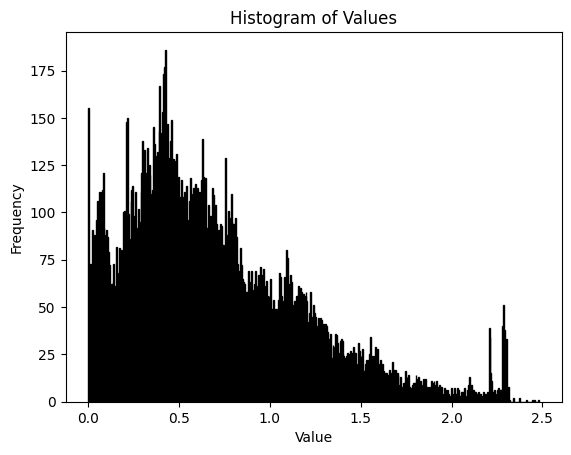

In [4]:
plt.hist(flattened, bins=500, edgecolor='black')  
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [5]:
train_split = 0.8

train_sequences, test_sequences = sequences[:int(len(sequences) * train_split)], sequences[int(len(sequences) * train_split):]
X_train, y_train, X_test_ordered, y_test_ordered = list(), list(), list(), list()

for sequence in test_sequences:
    seq_mod_X, seq_mod_y = list(), list()
    for i in range(len(sequence) - input_window):
        sequence_x_temp = sequence[i:i+input_window]
        sequence_y_temp = sequence[i+input_window:i+input_window+output_window]
        sequence_x_temp = (sequence_x_temp - mean) / std # STANDARDIZATION
        sequence_y_temp = (sequence_y_temp - mean) / std # STANDARDIZATION
        seq_mod_X.append(sequence_x_temp)
        seq_mod_y.append(sequence_y_temp)
    X_test_ordered.append(seq_mod_X)
    y_test_ordered.append(seq_mod_y)

for sequence in train_sequences:
    for i in range(len(sequence) - input_window):
        sequence_x_temp = sequence[i:i+input_window]
        sequence_y_temp = sequence[i+input_window:i+input_window+output_window]
        sequence_x_temp = (sequence_x_temp - mean) / std # STANDARDIZATION
        sequence_y_temp = (sequence_y_temp - mean) / std # STANDARDIZATION
        X_train.append(sequence_x_temp)
        y_train.append(sequence_y_temp)

X_train, y_train = np.array(X_train), np.array(y_train)
print("X shape:", X_train.shape, "\ny shape:", y_train.shape)

X shape: (18797, 9) 
y shape: (18797, 1)


## Dataset creation

In [6]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        input_sequence = self.X[idx]
        target_value = self.y[idx]
        return torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(-1), torch.tensor(target_value, dtype=torch.float32)
        # tensor([[ 1.6746], [ 1.0198], [ 0.7197], [ 0.4992], [ 0.3248], [ 0.1785], [ 0.0479] [-0.0584], [-0.1603], [-0.2594]])

# Create DataLoader for training and testing sets
train_dataset = SequenceDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model Architecture

In [10]:
class FloatSequenceTransformer(nn.Module):
    def __init__(self, seq_length, embedding_dim=64, num_heads=4, num_layers=6, dropout=0.2):
        super(FloatSequenceTransformer, self).__init__()
        
        self.embedding = nn.Linear(1, embedding_dim)
        self.register_buffer("positional_encoding", generate_positional_encoding(seq_length, embedding_dim))
        
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=num_heads, 
            batch_first=True, 
            dropout=dropout
        )
        
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(embedding_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        x = x + self.positional_encoding  # Add positional encoding

        # Create causal mask for Transformer
        mask = torch.triu(torch.ones(x.size(1), x.size(1), device=x.device) * float('-inf'), diagonal=1)
        
        x = self.transformer(x, mask=mask)
        x = self.output_layer(x[:, -1, :])  # Output from the last position
        return x


# Positional encoding function
def generate_positional_encoding(seq_length, embedding_dim):
    position = torch.arange(seq_length).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(np.log(10000.0) / embedding_dim))
    
    pe = torch.zeros(seq_length, embedding_dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe


# Instantiate model, loss, optimizer, and scheduler
seq_length = input_window
model = FloatSequenceTransformer(seq_length=seq_length)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Halve LR every 5 epochs


## Training

In [11]:
clip_value = 1.0

num_epochs = 10
train_loss_history = []

# Training Loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        # Optimization step
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Adjust learning rate
    scheduler.step()
    
    # Calculate average loss for this epoch
    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

 10%|████████▏                                                                         | 1/10 [01:49<16:21, 109.03s/it]

Epoch [1/10], Train Loss: 0.0215, LR: 0.000500


 20%|████████████████▍                                                                 | 2/10 [03:38<14:36, 109.52s/it]

Epoch [2/10], Train Loss: 0.0075, LR: 0.000500


 30%|████████████████████████▌                                                         | 3/10 [05:26<12:42, 108.86s/it]

Epoch [3/10], Train Loss: 0.0045, LR: 0.000500


 40%|████████████████████████████████▊                                                 | 4/10 [07:11<10:41, 106.98s/it]

Epoch [4/10], Train Loss: 0.0051, LR: 0.000500


 50%|█████████████████████████████████████████                                         | 5/10 [08:59<08:56, 107.39s/it]

Epoch [5/10], Train Loss: 0.0037, LR: 0.000250


 60%|█████████████████████████████████████████████████▏                                | 6/10 [10:46<07:08, 107.24s/it]

Epoch [6/10], Train Loss: 0.0023, LR: 0.000250


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [12:31<05:20, 106.71s/it]

Epoch [7/10], Train Loss: 0.0021, LR: 0.000250


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [14:17<03:32, 106.43s/it]

Epoch [8/10], Train Loss: 0.0018, LR: 0.000250


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [16:02<01:45, 106.00s/it]

Epoch [9/10], Train Loss: 0.0019, LR: 0.000250


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [17:47<00:00, 106.78s/it]

Epoch [10/10], Train Loss: 0.0017, LR: 0.000125


## Test trained model

In [12]:
def predict_next_value(model, sequence):
    model.eval()
    with torch.no_grad():
        input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1) # Shape: (1, seq_length, 1)
        prediction = model(input_sequence)
        return prediction.item()

for sequence_x, sequence_y in zip(X_test_ordered, y_test_ordered): 
    for input_x, y_real in zip(sequence_x, sequence_y):
        y_hat = predict_next_value(model, input_x)
        print("y_hat:", y_hat * std + mean, "y_real:", y_real[0] * std + mean)
    break

y_hat: 1.354532608575032 y_real: 1.3438
y_hat: 1.3417358293079404 y_real: 1.3347
y_hat: 1.3299614889113234 y_real: 1.3257
y_hat: 1.3193658190028215 y_real: 1.3148
y_hat: 1.3106841597443086 y_real: 1.3086
y_hat: 1.3053881736849409 y_real: 1.2954
y_hat: 1.296263819657804 y_real: 1.2935
y_hat: 1.2924894163094414 y_real: 1.2844
y_hat: 1.2858425236479847 y_real: 1.2733
y_hat: 1.2780095649188798 y_real: 1.2709
y_hat: 1.2735279592776485 y_real: 1.2584
y_hat: 1.2642098179555536 y_real: 1.2604
y_hat: 1.2621797891516362 y_real: 1.2483
y_hat: 1.2539806914576692 y_real: 1.2502
y_hat: 1.2529542659076025 y_real: 1.2446
y_hat: 1.249044431009037 y_real: 1.2336


In [13]:
results = []
for sequence_x, sequence_y in zip(X_test_ordered, y_test_ordered): 
    real_sequence, predicted_sequence = list(sequence_x[0]*std + mean), list(sequence_x[0]*std + mean)
    for input_x, y_real in zip(sequence_x, sequence_y):
        y_hat = predict_next_value(model, input_x)
        y_hat, y_real = y_hat * std + mean , y_real * std + mean  # transform back to initial scale
        real_sequence.append(y_real[0]), predicted_sequence.append(y_hat)
    results.append((real_sequence, predicted_sequence))

### Plot some of the predicted results

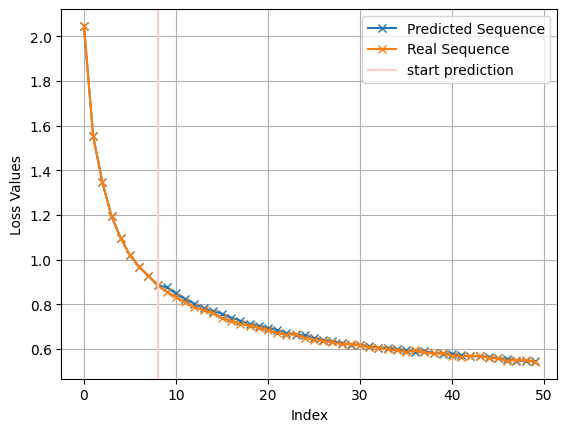

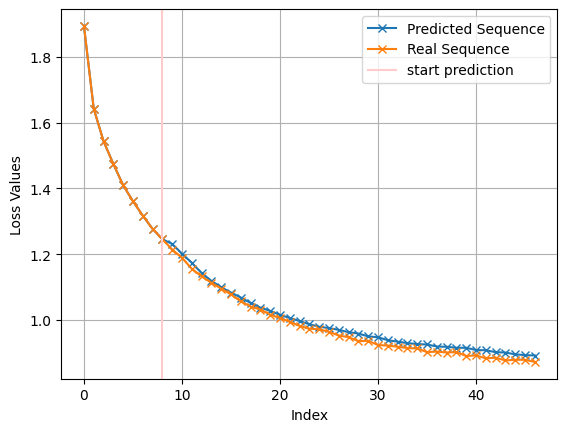

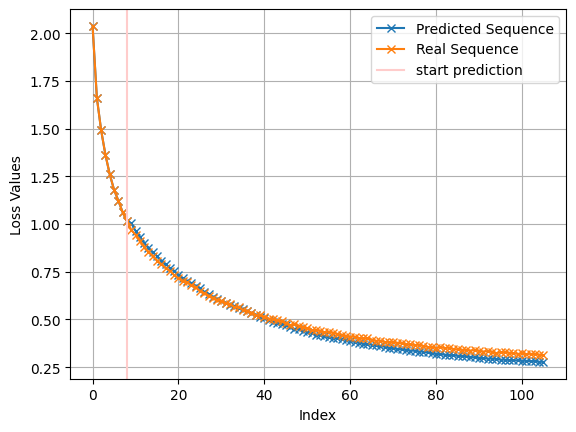

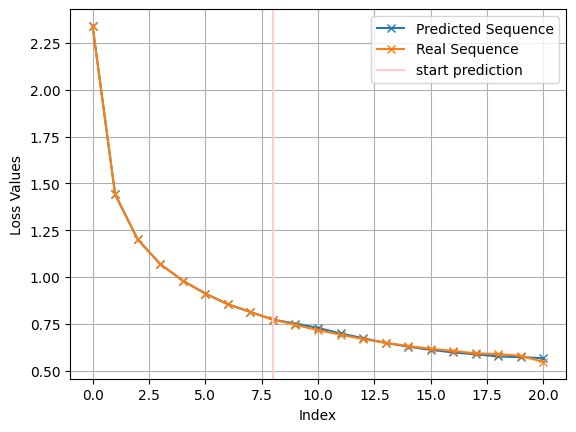

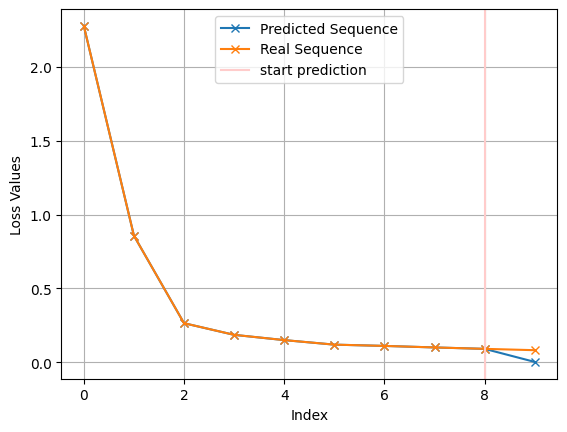

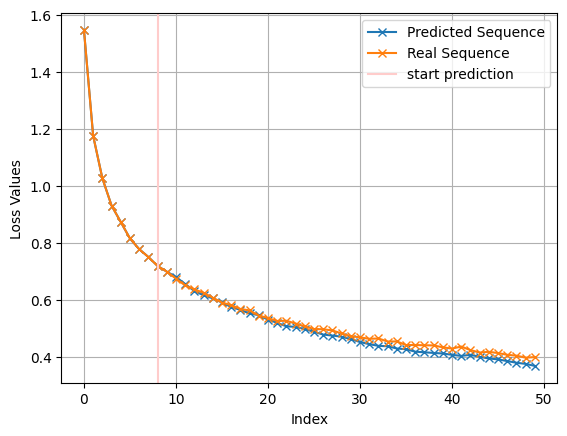

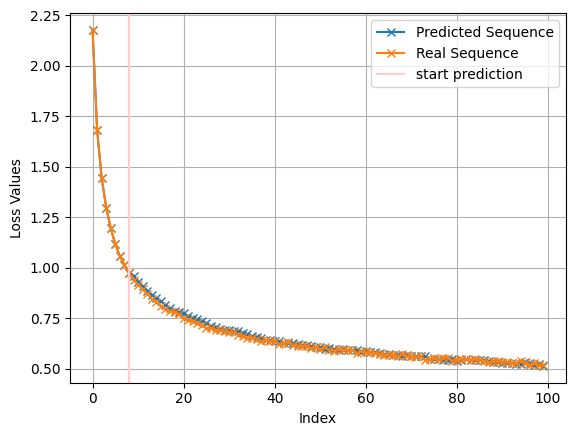

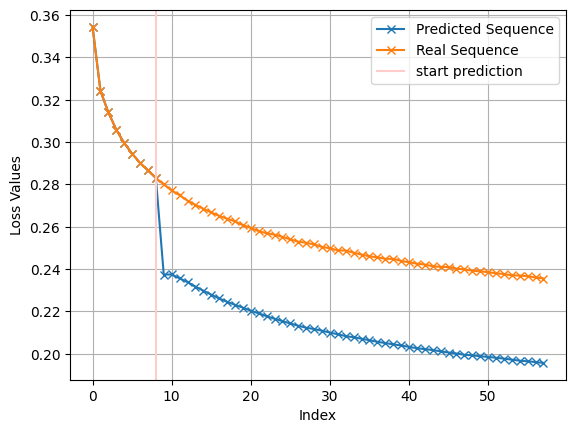

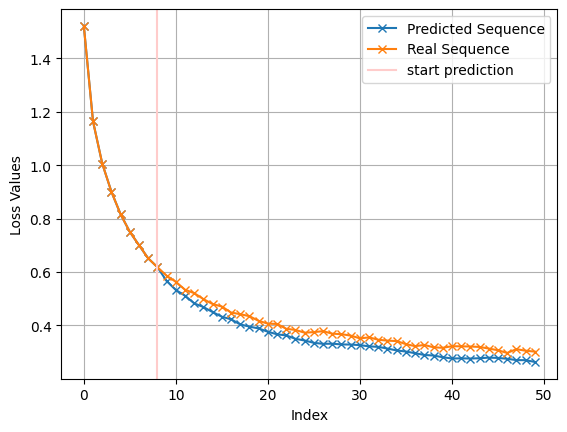

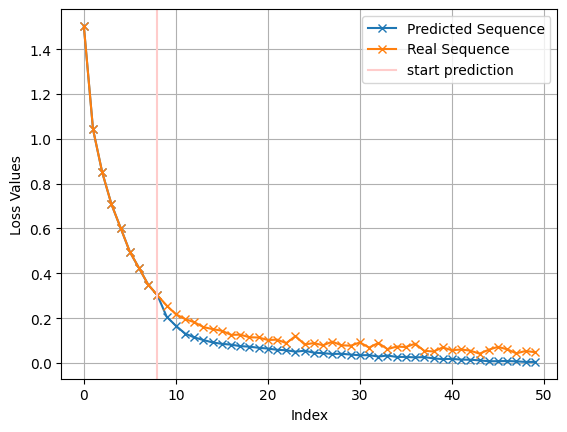

In [14]:
num_samples = 10

sample = random.sample(results, num_samples)
for i, (real_sequence, predicted_sequence) in enumerate(sample):
    plt.figure()
    plt.plot(predicted_sequence, label="Predicted Sequence", marker='x', linestyle='-')
    plt.plot(real_sequence, label="Real Sequence", marker='x', linestyle='-')
    plt.axvline(x=input_window-1, color='#ffcccb', linestyle='-', label="start prediction")
    plt.xlabel("Index")
    plt.ylabel("Loss Values")
    plt.legend()
    plt.grid()
    plt.show()

### Only use first 10 loss values and then let the transfomer take each own output as input for prediction of next loss value

In [15]:
results_hallucinate = []
for sequence_x, sequence_y in zip(X_test_ordered, y_test_ordered): 
    if not sequence_x:
        continue
    real_sequence, predicted_sequence = list(sequence_x[0]*std + mean), list(sequence_x[0]*std + mean)
                                                                             
    for ix, (input_x, y_real) in enumerate(zip(sequence_x, sequence_y)):
        if ix == 0:
            previous_input = input_x
        y_hat = predict_next_value(model, previous_input)
        previous_input = np.concatenate((previous_input[1:], np.array([y_hat])))
        
        y_hat, y_real = y_hat * std + mean , y_real * std + mean  # transform back to initial scale
        real_sequence.append(y_real[0]), predicted_sequence.append(y_hat)
    results_hallucinate.append((real_sequence, predicted_sequence))

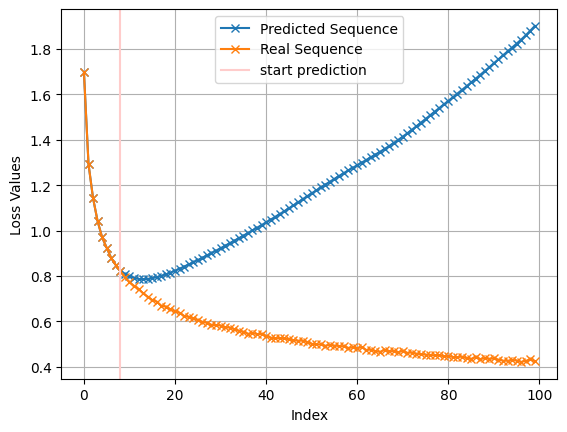

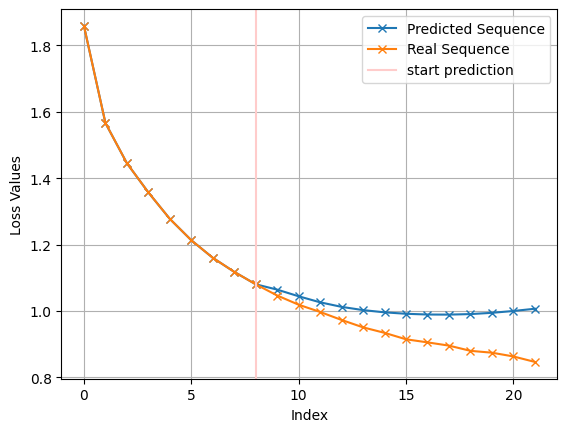

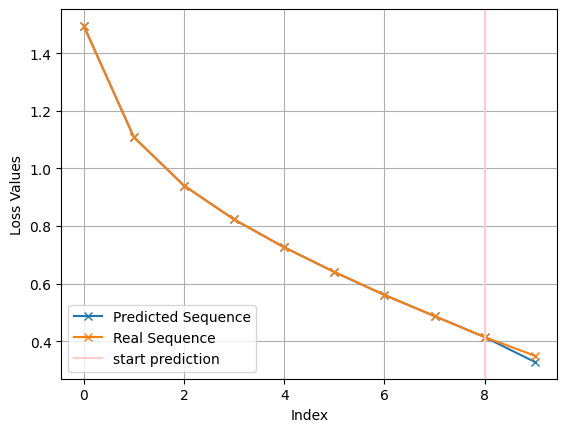

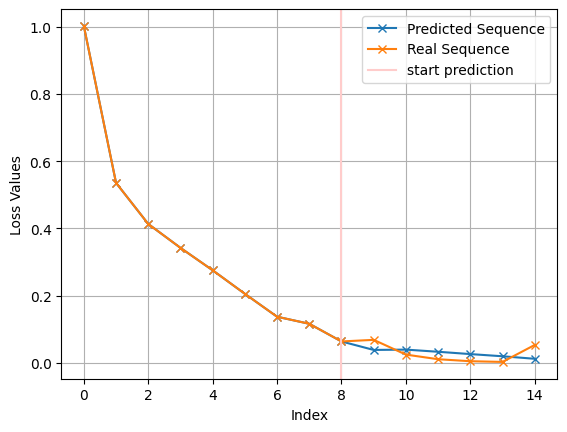

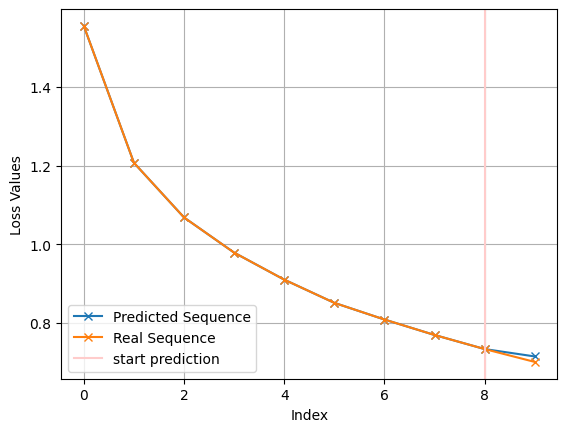

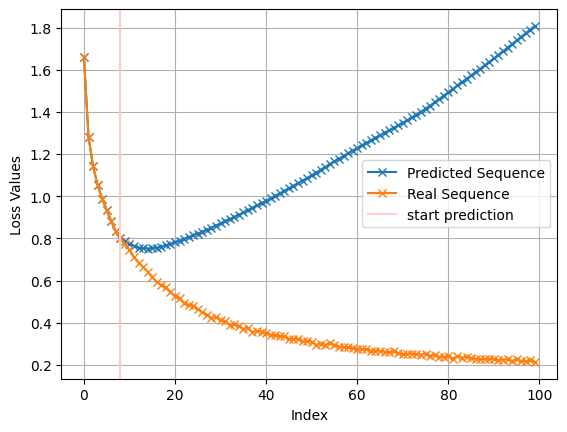

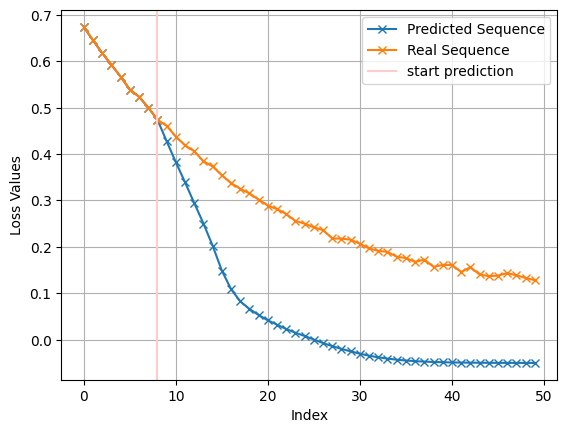

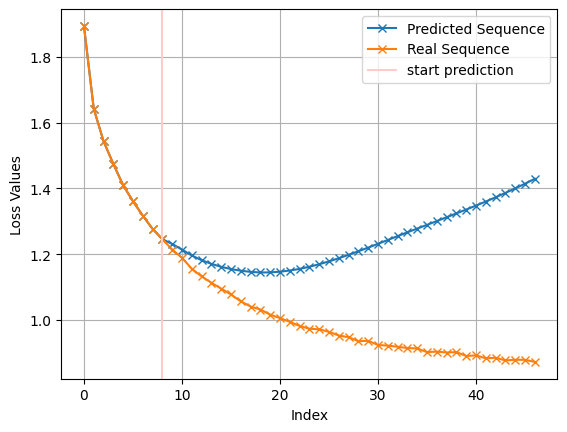

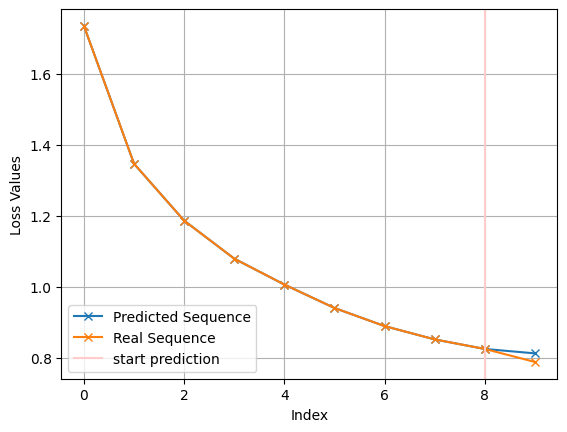

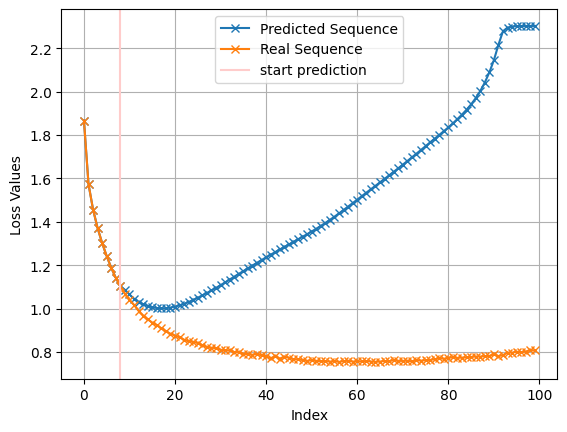

In [16]:
num_samples = 10

sample = random.sample(results_hallucinate, num_samples)
for i, (real_sequence, predicted_sequence) in enumerate(sample):
    plt.figure()
    plt.plot(predicted_sequence, label="Predicted Sequence", marker='x', linestyle='-')
    plt.plot(real_sequence, label="Real Sequence", marker='x', linestyle='-')
    plt.axvline(x=input_window-1, color='#ffcccb', linestyle='-', label="start prediction")
    
    plt.xlabel("Index")
    plt.ylabel("Loss Values")
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
model_save_path = "models/trained_model_fixed_length.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/trained_model_fixed_length.pth
